In [73]:
import os
import pandas as pd
import numpy as np
from string import punctuation
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix

In [2]:
f_name = 'rotten_tomatoes_movies.csv'
raw_data = pd.read_csv(f_name)
raw_data.head(2)

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19


### Column Description
**movie_title**: title of the movie as displayed on the Rotten Tomatoes website.<br>
**critics_consensus**: comment from Rotten Tomatoes<br>
**content_rating**: category based on the movie suitability for audience<br>
**genres**: movie genres separated by commes, if multiple<br>
**runtime**: movie runtume (in minutes)<br>
**tomatometer_status**: tomatometer value of "Rotten" (less than 60% positive reviews), "Fresh" (at least 60% of positive reviews), and "Certified Fresh" (at least 75% of positive reviews, at least 80 reviews of which at least 5 from top critics)<br>
**tomatometer_rating**: percentage of positive critic ratings<br>
**audience_status**: audience value of "Spilled" (less than 60% of users gave a rating of at least 3.5) or "Upright" (at least 60% of users gave a rating of at least 3.5)<br>
**audience_rating**: percentage of positive user ratings<br>

In [3]:
#selecting needed columns
columns = ['movie_title', 'audience_rating', 'runtime', 'content_rating', 'audience_status', 
           'audience_status', 'genres', 'critics_consensus']
movies_info =raw_data[columns] 
movies_info.head(2)

,movie_title,audience_rating,runtime,content_rating,audience_status,audience_status,genres,critics_consensus
0,Percy Jackson & the Olympians: The Lightning T...,53.0,119.0,PG,Spilled,Spilled,"Action & Adventure, Comedy, Drama, Science Fic...",Though it may seem like just another Harry Pot...
1,Please Give,64.0,90.0,R,Upright,Upright,Comedy,Nicole Holofcener's newest might seem slight i...


In [4]:
#depending on what analysis we will like to do, we can drop rows with NULL values
movies_info.info()
movies_info.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_title        17712 non-null  object 
 1   audience_rating    17416 non-null  float64
 2   runtime            17398 non-null  float64
 3   content_rating     17712 non-null  object 
 4   audience_status    17264 non-null  object 
 5   audience_status    17264 non-null  object 
 6   genres             17693 non-null  object 
 7   critics_consensus  9134 non-null   object 
dtypes: float64(2), object(6)
memory usage: 1.1+ MB


,audience_rating,runtime
count,17416.000000,17398.000000
mean,60.554260,102.214048
std,20.543369,18.702511
min,0.000000,5.000000
25%,45.000000,90.000000
50%,63.000000,99.000000
75%,78.000000,111.000000
max,100.000000,266.000000


colums_for_predicting_genre = ['movie_title', 'runtime', 'genres', 'actors', 'directors', 'production_company']
genre_info = raw_data[colums_for_predicting_genre]

genre_info.head(2)

### Workinging on movie info

In [5]:
#Dropping nan values first since we have alot of missing value in the critice_consensus column
movie_nona = movies_info.dropna()
movie_nona.reset_index(drop=True).head(2)                  

,movie_title,audience_rating,runtime,content_rating,audience_status,audience_status,genres,critics_consensus
0,Percy Jackson & the Olympians: The Lightning T...,53.0,119.0,PG,Spilled,Spilled,"Action & Adventure, Comedy, Drama, Science Fic...",Though it may seem like just another Harry Pot...
1,Please Give,64.0,90.0,R,Upright,Upright,Comedy,Nicole Holofcener's newest might seem slight i...


## 1.1 Data Prep for Analysis
**Text Analysis (critics_concensus)**

In [6]:
text = movie_nona['critics_consensus'].astype(str)
text.head(2)

0    Though it may seem like just another Harry Pot...
1    Nicole Holofcener's newest might seem slight i...
Name: critics_consensus, dtype: object

In [7]:
#change to lower_case
text_lowercase = text.str.lower()
text_lowercase.astype(str).head(2)

0    though it may seem like just another harry pot...
1    nicole holofcener's newest might seem slight i...
Name: critics_consensus, dtype: object

In [8]:
#Removing Punctuation and digits
def remove_punct_dig(document):
    no_punct = ''.join([character for character in document if character not in punctuation])
    no_punct_dij = ''.join([character for character in no_punct if not character.isdigit()])
    return no_punct_dij

In [9]:
text_no_p_d = text_lowercase.apply(remove_punct_dig)
text_no_p_d.head(2)

0    though it may seem like just another harry pot...
1    nicole holofceners newest might seem slight in...
Name: critics_consensus, dtype: object

In [10]:
#Tokenization
text_tokenized = text_no_p_d.apply(word_tokenize)
text_tokenized.head(2)

0    [though, it, may, seem, like, just, another, h...
1    [nicole, holofceners, newest, might, seem, sli...
Name: critics_consensus, dtype: object

In [11]:
#Removing Stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(document):
    words = [word for word in document if not word in stop_words]
    return words

In [12]:
text_no_stop = text_tokenized.apply(remove_stopwords)
text_no_stop.head(2)

0    [though, may, seem, like, another, harry, pott...
1    [nicole, holofceners, newest, might, seem, sli...
Name: critics_consensus, dtype: object

In [13]:
#Stemming
porter = PorterStemmer()

def stemmer(document):    
    stemmed_document = [porter.stem(word) for word in document]    
    return stemmed_document

In [14]:
text_stemmed = text_no_stop.apply(stemmer)
text_stemmed.head(2)

0    [though, may, seem, like, anoth, harri, potter...
1    [nicol, holofcen, newest, might, seem, slight,...
Name: critics_consensus, dtype: object

In [15]:
#Detokenization
text_detokenized = text_stemmed.apply(TreebankWordDetokenizer().detokenize)
text_detokenized.head(2)

0    though may seem like anoth harri potter knocko...
1    nicol holofcen newest might seem slight place ...
Name: critics_consensus, dtype: object

In [16]:
# Document-term Matrix
countvec = CountVectorizer(min_df=0.03)

sparse_dtm = countvec.fit_transform(text_detokenized)
sparse_dtm

<8898x46 sparse matrix of type '<class 'numpy.int64'>'
	with 19277 stored elements in Compressed Sparse Row format>

In [17]:
dtm_pre = pd.DataFrame(sparse_dtm.toarray(), columns=countvec.get_feature_names_out(), index=text.index)
dtm = dtm_pre.add_suffix('_critic')


In [18]:
frequencies = dtm_pre.sum().sort_values(ascending=False)
print(frequencies[frequencies > 30])

perform      1360
stori         857
film          712
cast          704
movi          626
make          592
offer         588
comedi        539
charact       505
enough        500
may           456
drama         449
thriller      435
director      431
plot          430
visual        427
entertain     411
work          390
effect        379
action        376
talent        373
look          369
power         367
charm         359
one           353
viewer        345
though        342
star          340
lack          339
funni         335
fan           332
direct        323
thrill        318
featur        316
humor         312
script        309
genr          307
life          305
strong        304
take          295
even          284
classic       276
horror        274
time          274
lead          273
origin        271
dtype: int64


In [19]:
#combining into one
movies_info_pre_processed = movie_nona[['audience_rating', 'runtime', 'content_rating',
                                     'audience_status', 'genres']].join(dtm)

movies_info_pre_processed.head(2)

,audience_rating,runtime,content_rating,audience_status,audience_status,genres,action_critic,cast_critic,charact_critic,charm_critic,...,strong_critic,take_critic,talent_critic,though_critic,thrill_critic,thriller_critic,time_critic,viewer_critic,visual_critic,work_critic
0,53.0,119.0,PG,Spilled,Spilled,"Action & Adventure, Comedy, Drama, Science Fic...",0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
1,64.0,90.0,R,Upright,Upright,Comedy,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# FOrmular to convert audience_rating to range between 0-10

def get_range(value):
    if pd.isna(value):
        return 0
    else:
        digit = value / 10
        return int(digit)

In [21]:
new_rating = movies_info_pre_processed['audience_rating'].apply(get_range)
new_rating

0        5
1        6
2        5
3        9
4        7
        ..
17704    8
17705    2
17706    3
17708    9
17710    9
Name: audience_rating, Length: 8898, dtype: int64

In [22]:
movies_info_pre_processed['audience_rating'] = new_rating
movies_info_pre_processed.head(2)

,audience_rating,runtime,content_rating,audience_status,audience_status,genres,action_critic,cast_critic,charact_critic,charm_critic,...,strong_critic,take_critic,talent_critic,though_critic,thrill_critic,thriller_critic,time_critic,viewer_critic,visual_critic,work_critic
0,5,119.0,PG,Spilled,Spilled,"Action & Adventure, Comedy, Drama, Science Fic...",0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
1,6,90.0,R,Upright,Upright,Comedy,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Changing categorical varieables in columns to numerical data
movies_info_processed = pd.get_dummies(movies_info_pre_processed, columns=['content_rating', 'audience_status', 'genres'])
movies_info_processed.head(2)


,audience_rating,runtime,action_critic,cast_critic,charact_critic,charm_critic,classic_critic,comedi_critic,direct_critic,director_critic,...,"genres_Mystery & Suspense, Special Interest","genres_Mystery & Suspense, Television","genres_Mystery & Suspense, Western",genres_Romance,genres_Science Fiction & Fantasy,"genres_Science Fiction & Fantasy, Romance","genres_Science Fiction & Fantasy, Special Interest","genres_Science Fiction & Fantasy, Western",genres_Television,genres_Western
0,5,119.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,90.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/Users/adedeji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


8     1648
7     1632
6     1409
5     1234
4     1108
3      784
9      592
2      367
1      112
10       8
0        4
Name: audience_rating, dtype: int64


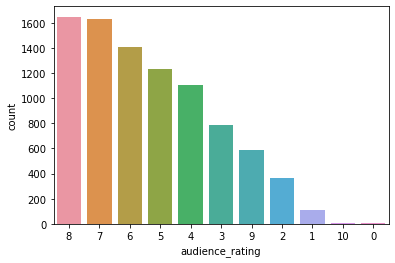

In [24]:

#Checking if our classed are evenly distributed
sns.countplot(movies_info_processed['audience_rating'], order=movies_info_processed['audience_rating'].value_counts().index);
print(movies_info_processed['audience_rating'].value_counts())

## 1.2 Decision Tree Regression

In [25]:
y = movies_info_processed['audience_rating']
x = movies_info_processed.drop(['audience_rating'], axis=1)

In [26]:
y.isna().sum()

0

In [27]:
x.isna().sum()

runtime                                               0
action_critic                                         0
cast_critic                                           0
charact_critic                                        0
charm_critic                                          0
                                                     ..
genres_Science Fiction & Fantasy, Romance             0
genres_Science Fiction & Fantasy, Special Interest    0
genres_Science Fiction & Fantasy, Western             0
genres_Television                                     0
genres_Western                                        0
Length: 742, dtype: int64

In [28]:
from sklearn.model_selection import train_test_split

y = y.astype('int32')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=88)
x_train.shape, x_test.shape

((6228, 742), (2670, 742))

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

grid_values = {'ccp_alpha': np.linspace(0, 0.008, 100),
              'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]}

dtc = DecisionTreeRegressor(random_state=88)
dtc_cv = GridSearchCV(dtc, param_grid=grid_values,  cv=2).fit(x_train, y_train)

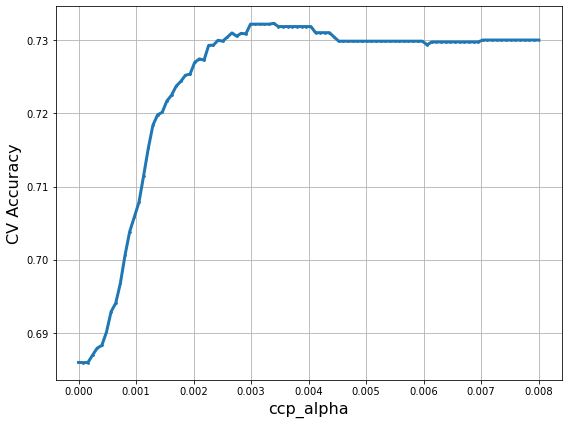

Best ccp_alpha {'ccp_alpha': 0.003393939393939394, 'max_depth': 30, 'min_samples_leaf': 5, 'min_samples_split': 20, 'random_state': 88}


In [30]:
import matplotlib.pyplot as plt

ccp_alpha = dtc_cv.cv_results_['param_ccp_alpha'].data
ACC_scores = dtc_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV Accuracy', fontsize=16)
plt.scatter(ccp_alpha, ACC_scores, s=3)
plt.plot(ccp_alpha, ACC_scores, linewidth=3)
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

print('Best ccp_alpha', dtc_cv.best_params_)

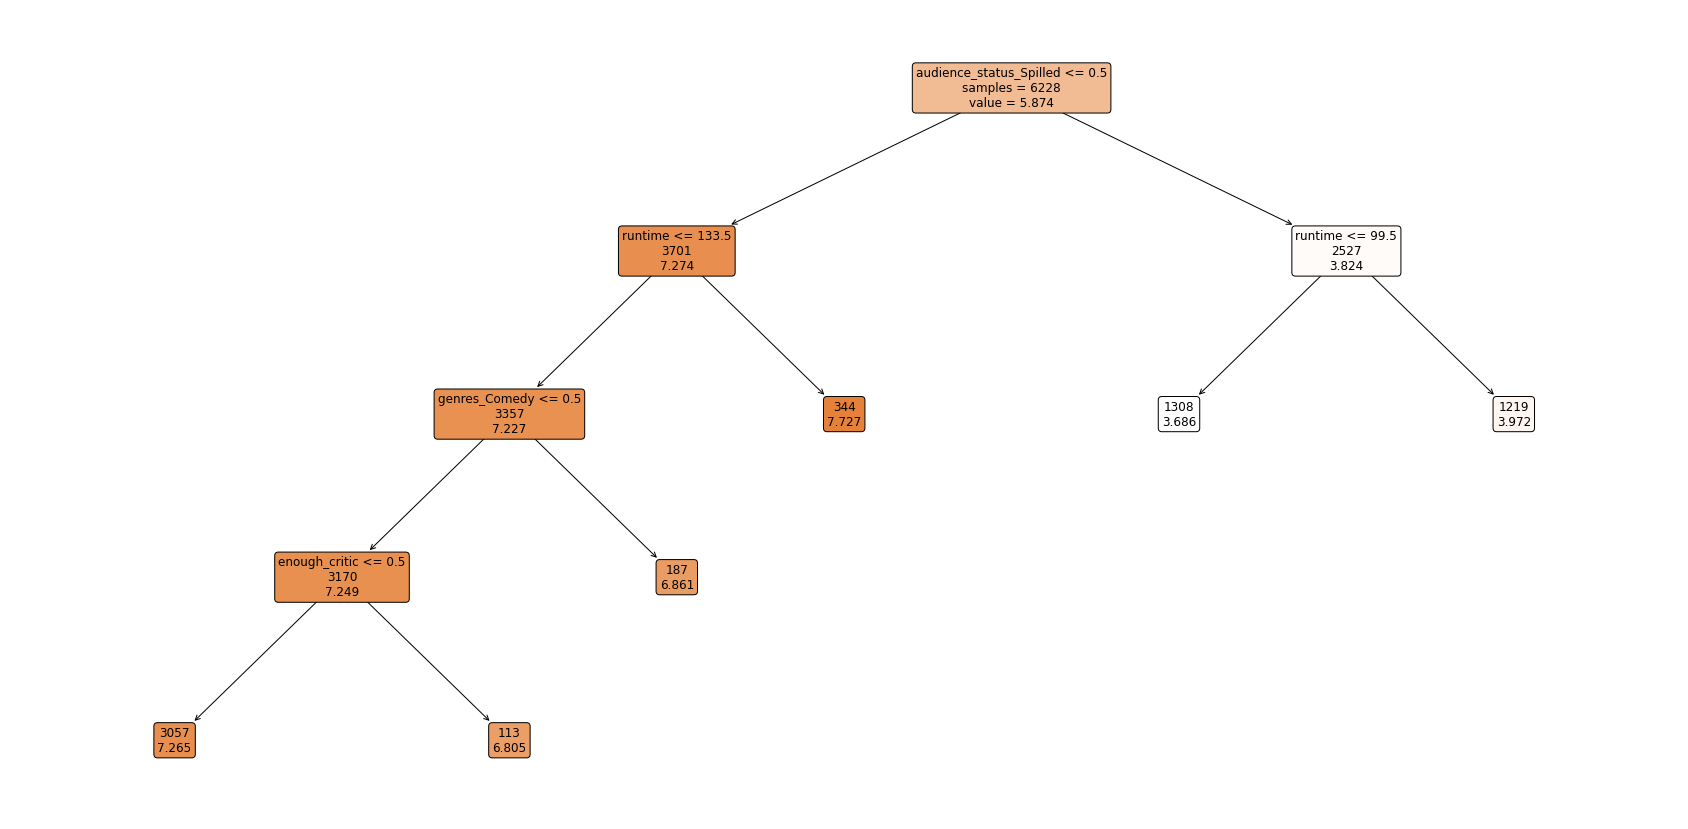

In [31]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30,15))
plot_tree(dtc_cv.best_estimator_, 
          feature_names=x_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12,
          max_depth = 5,
          label='root')
plt.show()

In [32]:
from sklearn.metrics import r2_score

print('CV R2:', round(dtc_cv.best_score_, 5))
print('OSR2:', round(r2_score(y_test, dtc_cv.predict(x_test)), 5))

CV R2: 0.73233
OSR2: 0.73475


## 1.3 Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [35]:
### Random Forest Regressor with CV
import time

grid_values = {'max_features': np.linspace(1,120,120, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [100],
               'random_state': [88]} 

tic = time.time()

rf = RandomForestRegressor() 
rf_cv = GridSearchCV(rf, param_grid=grid_values, cv=5)
rf_cv.fit(x_train, y_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

time: 760.41 s


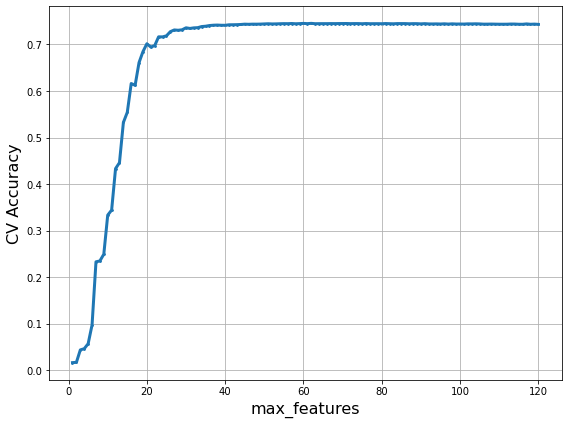

Best parameters {'max_features': 62, 'min_samples_leaf': 5, 'n_estimators': 100, 'random_state': 88}


In [36]:
max_features = rf_cv.cv_results_['param_max_features'].data
ACC_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max_features', fontsize=16)
plt.ylabel('CV Accuracy', fontsize=16)
plt.scatter(max_features, ACC_scores, s=3)
plt.plot(max_features, ACC_scores, linewidth=3)
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

print('Best parameters', rf_cv.best_params_)

In [37]:
x_test['runtime'].size

2670

In [38]:
pd.DataFrame({'Feature' :x_train.columns, 
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)

,Feature,Importance score
0,runtime,2.4
1,action_critic,0.0
2,cast_critic,0.1
3,charact_critic,0.0
4,charm_critic,0.1
...,...,...
737,"genres_Science Fiction & Fantasy, Romance",0.0
738,"genres_Science Fiction & Fantasy, Special Inte...",0.0
739,"genres_Science Fiction & Fantasy, Western",0.0
740,genres_Television,0.0


In [39]:
from sklearn.metrics import r2_score

print('CV R2:', round(rf_cv.best_score_, 5))
print('OSR2:', round(r2_score(y_test, rf_cv.predict(x_test)), 5))

CV R2: 0.74529
OSR2: 0.75124


## 1.4 XGBost for Regression

In [40]:
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE

In [41]:
#This is to deal with the error assocoated with uniquness of our features(duplicate columns)
X_train = x_train.loc[:,~x_train.columns.duplicated()].copy()
X_test = x_test.loc[:,~x_test.columns.duplicated()].copy()

In [42]:
# Various hyper-parameters to tune
xgb1 = xg.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=False)

xgb_grid.fit(X_train,
         y_train)



[23:26:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=5,
             param_grid={'colsample_by

In [43]:
print('CV R2:', xgb_grid.best_score_, 5)
XG_OSR2 = r2_score(y_test, xgb_grid.predict(X_test))
print('OSR2:', round(XG_OSR2, 5))
print('Best parameters', xgb_grid.best_params_)

CV R2: 0.7427905573929963 5
OSR2: 0.75172
Best parameters {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


## 1.5  Bootstrap Validation with Confidence Interval Plot 

**Since oure best model is XGBoost with OSR2 of 0.75172, we will like to know with certainty how it will perform on future data**

In [44]:
# manual implementation of bootstrap for model valiation.
def bootstrap_validation(test_data, test_label, train_label, model, metrics_list, sample=500, random_state=66):
    n_sample = sample
    n_metrics = len(metrics_list)
    output_array=np.zeros([n_sample, n_metrics])
    output_array[:]=np.nan
    print(output_array.shape)
    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        for metrics_iter in range(n_metrics):
            metrics = metrics_list[metrics_iter]
            output_array[bs_iter, metrics_iter]=metrics(bs_label, bs_predicted)                                                                                                                                                                                                                                                                                                         
    output_df = pd.DataFrame(output_array)
    return output_df

In [45]:
bs_output = bootstrap_validation(X_test,y_test,y_train,xgb_grid,
                                 metrics_list=[r2_score],
                                 sample = 5000)

(5000, 1)
[23:18:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[23:20:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[23:22:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[23:18:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[23:21:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[23:23:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10

#### 2.3.1 Basic plot and centered plot

(array([  1.,   0.,   5.,   7.,  26.,  96., 195., 328., 548., 743., 793.,
        810., 666., 423., 223.,  95.,  30.,  10.,   0.,   1.]),
 array([-0.02541116, -0.02301906, -0.02062697, -0.01823487, -0.01584277,
        -0.01345068, -0.01105858, -0.00866648, -0.00627439, -0.00388229,
        -0.0014902 ,  0.0009019 ,  0.003294  ,  0.00568609,  0.00807819,
         0.01047029,  0.01286238,  0.01525448,  0.01764658,  0.02003867,
         0.02243077]),
 <BarContainer object of 20 artists>)

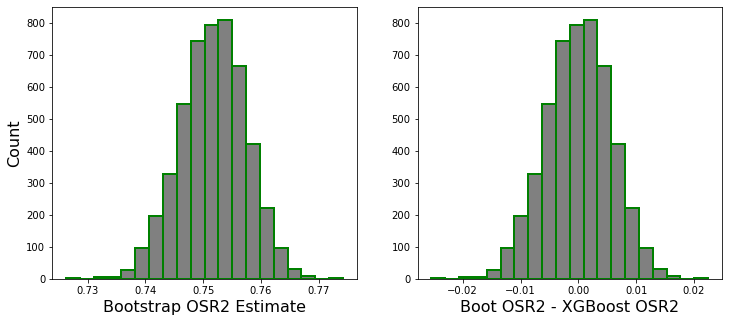

In [46]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Bootstrap OSR2 Estimate', fontsize=16)
axs[1].set_xlabel('Boot OSR2 - XGBoost OSR2', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bs_output.iloc[:,0], bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[1].hist(bs_output.iloc[:,0]-XG_OSR2, bins=20,edgecolor='green', linewidth=2,color = "grey")

#### manual CI + plot

In [47]:
# The 95% confidence interval
CI= np.quantile(bs_output.iloc[:,0]-XG_OSR2,np.array([0.025,0.975]))
print("The 95-percent confidence interval of OSR2 is %s" % CI)

The 95-percent confidence interval of OSR2 is [-0.01138854  0.01064887]


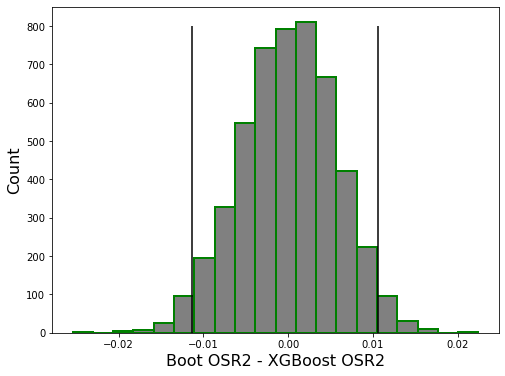

In [48]:
fig, axs = plt.subplots(ncols=1, figsize=(8,6))
axs.set_xlabel('Boot OSR2 - XGBoost OSR2', fontsize=16)
axs.set_ylabel('Count', fontsize=16)
axs.hist(bs_output.iloc[:,0]-XG_OSR2, bins=20,edgecolor='green', linewidth=2,color = "grey")
#axs.set_xlim([-0.15,0.15])
axs.vlines(x=CI[0], ymin = 0, ymax =800, color = "black")
axs.vlines(x=CI[1], ymin = 0, ymax =800, color = "black")

**In conclusion, since our confident interval contains Zero, we can say with 95% cofidence that our model will
generate very similar result on future datasets**




# Second Analysis

## 2.1 Data Prep for Analysis
**Text analysis for Actor column**

In [49]:
pre_text = raw_data[['actors', 'tomatometer_status', 'runtime', 'content_rating',
                       'genres','production_company','directors']]
pre_text_no_na = pre_text.dropna()
pre_text_no_na.reset_index(drop=True).head(2)

,actors,tomatometer_status,runtime,content_rating,genres,production_company,directors
0,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",Rotten,119.0,PG,"Action & Adventure, Comedy, Drama, Science Fic...",20th Century Fox,Chris Columbus
1,"Catherine Keener, Amanda Peet, Oliver Platt, R...",Certified-Fresh,90.0,R,Comedy,Sony Pictures Classics,Nicole Holofcener


In [50]:
text = pre_text_no_na['actors'].astype(str)
text.head(2)

0    Logan Lerman, Brandon T. Jackson, Alexandra Da...
1    Catherine Keener, Amanda Peet, Oliver Platt, R...
Name: actors, dtype: object

In [51]:
#change to lower_case
text_lowercase = text.str.lower()
text_lowercase.astype(str).head(2)

0    logan lerman, brandon t. jackson, alexandra da...
1    catherine keener, amanda peet, oliver platt, r...
Name: actors, dtype: object

In [52]:
text_no_p_d = text_lowercase.apply(remove_punct_dig)
text_no_p_d.head(2)

0    logan lerman brandon t jackson alexandra dadda...
1    catherine keener amanda peet oliver platt rebe...
Name: actors, dtype: object

In [53]:
text_tokenized = text_no_p_d.apply(word_tokenize)
text_tokenized.head(2)

0    [logan, lerman, brandon, t, jackson, alexandra...
1    [catherine, keener, amanda, peet, oliver, plat...
Name: actors, dtype: object

In [54]:
text_no_stop = text_tokenized.apply(remove_stopwords)
text_no_stop.head(2)

0    [logan, lerman, brandon, jackson, alexandra, d...
1    [catherine, keener, amanda, peet, oliver, plat...
Name: actors, dtype: object

In [55]:
text_stemmed = text_no_stop.apply(stemmer)
text_stemmed.head(2)

0    [logan, lerman, brandon, jackson, alexandra, d...
1    [catherin, keener, amanda, peet, oliv, platt, ...
Name: actors, dtype: object

In [56]:
#Detokenization
text_detokenized = text_stemmed.apply(TreebankWordDetokenizer().detokenize)
text_detokenized.head(2)

0    logan lerman brandon jackson alexandra daddari...
1    catherin keener amanda peet oliv platt rebecca...
Name: actors, dtype: object

In [57]:
# Document-term Matrix
countvec22 = CountVectorizer(min_df=0.01)

sparse_dtm1 = countvec22.fit_transform(text_detokenized)
sparse_dtm1

<16512x707 sparse matrix of type '<class 'numpy.int64'>'
	with 356288 stored elements in Compressed Sparse Row format>

In [58]:
dtm_pre = pd.DataFrame(sparse_dtm1.toarray(), columns=countvec22.get_feature_names_out(), index=text.index)
dtm = dtm_pre.add_suffix('_actor')

In [59]:
#Joining both data sets
new_raw_data = pre_text_no_na[['tomatometer_status', 'runtime', 'content_rating',
                       'genres','production_company','directors']].join(dtm)
new_raw_data = pd.get_dummies(new_raw_data, columns=['content_rating', 'genres','production_company','directors'], drop_first=True)


In [60]:
new_raw_data=new_raw_data[0:10000]

In [61]:
## converting string category of tomatometer_status into int

def get_status_score(value):
    if value =='Rotten':
        return 0
    elif value == 'Fresh':
        return 1
    elif value == 'Certified-Fresh':
        return 2
    else: 
        return 0

In [62]:
new_score = new_raw_data['tomatometer_status'].apply(get_status_score)
new_raw_data['tomatometer_status_score'] = new_score.astype(int)

new_raw_data.head(3)

,tomatometer_status,runtime,aaron_actor,abraham_actor,adam_actor,adrian_actor,al_actor,alan_actor,albert_actor,alec_actor,...,directors_Zoe Lister-Jones,directors_Zoltan Korda,directors_Zoya Akhtar,"directors_Zoya Akhtar, Anurag Kashyap, Dibakar Banerjee, Karan Johar",directors_Ágúst Guðmundsson,directors_Álex de la Iglesia,directors_Åke Sandgren,directors_Émile Gaudreault,directors_Éva Gárdos,tomatometer_status_score
0,Rotten,119.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Certified-Fresh,90.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,Fresh,122.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Rotten             4463
Fresh              3676
Certified-Fresh    1861
Name: tomatometer_status, dtype: int64


/Users/adedeji/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


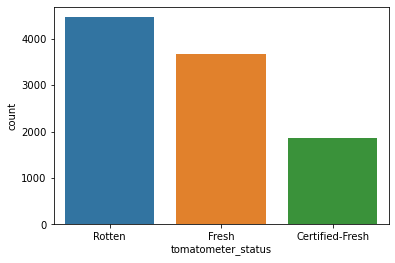

In [63]:
#Checking if our classed are evenly distributed
sns.countplot(new_raw_data['tomatometer_status'], order=new_raw_data['tomatometer_status'].value_counts().index);
print(new_raw_data['tomatometer_status'].value_counts())

In [64]:
#Separating dataset into dependent(Y) and independent(X) sets
y = new_raw_data['tomatometer_status_score']
x = new_raw_data.drop(['tomatometer_status_score', 'tomatometer_status'], axis=1)
new_raw_data.describe()

,runtime,aaron_actor,abraham_actor,adam_actor,adrian_actor,al_actor,alan_actor,albert_actor,alec_actor,alex_actor,...,directors_Zoe Lister-Jones,directors_Zoltan Korda,directors_Zoya Akhtar,"directors_Zoya Akhtar, Anurag Kashyap, Dibakar Banerjee, Karan Johar",directors_Ágúst Guðmundsson,directors_Álex de la Iglesia,directors_Åke Sandgren,directors_Émile Gaudreault,directors_Éva Gárdos,tomatometer_status_score
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.0000,10000.000000,10000.0000,10000.0000,10000.0,10000.000000,10000.0,10000.0000,10000.0000,10000.0000
mean,102.873400,0.042000,0.010600,0.099600,0.024800,0.040500,0.081300,0.029400,0.014000,0.067400,...,0.0001,0.000400,0.0001,0.0001,0.0,0.000200,0.0,0.0001,0.0001,0.7398
std,18.864394,0.210334,0.103386,0.342186,0.161826,0.215092,0.301163,0.178714,0.119186,0.271044,...,0.0100,0.019997,0.0100,0.0100,0.0,0.014141,0.0,0.0100,0.0100,0.7515
min,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.0000,0.0000,0.0,0.000000,0.0,0.0000,0.0000,0.0000
25%,91.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.0000,0.0000,0.0,0.000000,0.0,0.0000,0.0000,0.0000
50%,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.0000,0.0000,0.0,0.000000,0.0,0.0000,0.0000,1.0000
75%,111.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.0000,0.0000,0.0,0.000000,0.0,0.0000,0.0000,1.0000
max,254.000000,3.000000,2.000000,4.000000,2.000000,3.000000,3.000000,2.000000,2.000000,4.000000,...,1.0000,1.000000,1.0000,1.0000,0.0,1.000000,0.0,1.0000,1.0000,2.0000


In [65]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y  = train_test_split(x, y, test_size=0.3, random_state=88)
train_x.shape, test_x.shape

((7000, 12965), (3000, 12965))

## 2.2  LDA

In [66]:
data_train_y=train_y.to_numpy()
data_train_x=train_x.to_numpy()

data_test_y=test_y.to_numpy()
data_test_x=test_x.to_numpy()

In [68]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
lda = LinearDiscriminantAnalysis(
)
lda.fit(data_train_x,data_train_y)

LinearDiscriminantAnalysis()

In [69]:
data_plot = lda.transform(data_train_x)

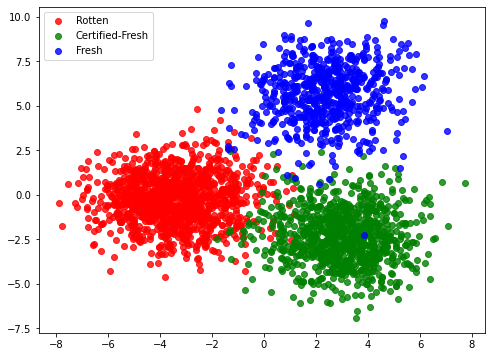

In [70]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

## set up the label and color of different classes for plotting.

tomatometer_status = new_raw_data.tomatometer_status
colors = ['red', 'green', 'blue']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], tomatometer_status):
    plt.scatter(data_plot[data_train_y == i, 0], data_plot[data_train_y == i, 1], alpha=.8, color=color,
                label=target_name)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

In [71]:
#predicting test set

y_prob_lda = lda.predict(data_test_x)
OSR2_lda = lda.score(data_test_x, data_test_y)
print('Model Precision (OSR2): ',round(OSR2_lda, 5))

Model Precision (OSR2):  0.45067


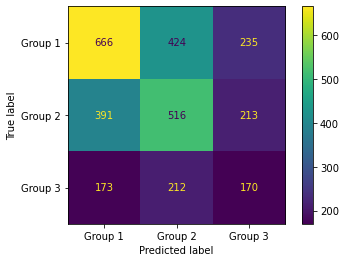

In [74]:
#Generating Confustion matrix fort the LDA Model.
cm_lda1 = confusion_matrix(data_test_y, y_prob_lda)
class_names = ['Group 1', 'Group 2', 'Group 3']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_lda1, display_labels = class_names)

cm_display.plot()
plt.show()

In [75]:
def TPR_FPR_ACC(cnf_matrix):
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
     
    # Fall out or false positive rate
    FPR = FP/(FP+TN)

    # Overall accuracy for each class
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return TPR, FPR, ACC

In [77]:
LDA_TPR, LDA_FPR, LDA_ACC = TPR_FPR_ACC(cm_lda1)
print('LDA_TPR : ',LDA_TPR)
print('LDA_FPR : ',LDA_FPR)
print('LDA_ACC : ',LDA_ACC)

LDA_TPR :  [0.50264151 0.46071429 0.30630631]
LDA_FPR :  [0.33671642 0.33829787 0.18323108]
LDA_ACC :  [0.59233333 0.58666667 0.72233333]


##  2.3 CART Model

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
# this package can apply to find best combination of parameters....

#Exhaustive search over specified parameter values for an estimator.

grid_values = {'ccp_alpha': np.linspace(0.0, 0.005, 5),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'class_weight' : [{0: 1, 1: 20}],
               'random_state': [88]} 
            
dtc = DecisionTreeClassifier(class_weight = 'balanced')

#best combo of  paramters to find best accuracy
dtc_cv_acc = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=10, verbose=0) 

# default scoring metric to optimize is accuracy, used as default if none given.
training = dtc_cv_acc.fit(train_x, train_y)

In [79]:
acc = dtc_cv_acc.cv_results_['mean_test_score'] 
# what sklearn calls mean_test_score is the holdout set, i.e. the validation set.
ccp = dtc_cv_acc.cv_results_['param_ccp_alpha'].data

pd.DataFrame({'ccp alpha' : ccp, 'Validation Accuracy': acc}).head(20)

#to find ccp value we test across different values.....
#verbose is the report meassgae about what you are modeling..


,ccp alpha,Validation Accuracy
0,0.0,0.417143
1,0.00125,0.365143
2,0.0025,0.365143
3,0.00375,0.365143
4,0.005,0.365143


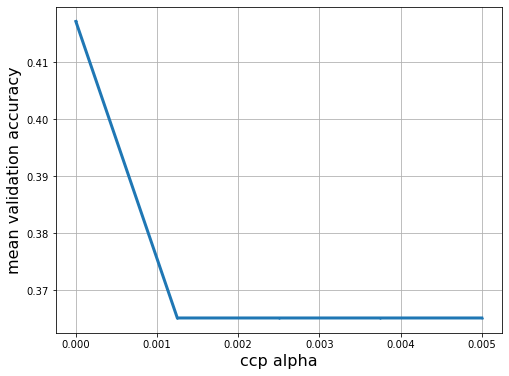

In [80]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(ccp, acc, s=2)
plt.plot(ccp, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

#visaulization is a good way to show why you are choosing thay parameter!!!

In [81]:
print('Grid best parameter (max. Accuracy): ', dtc_cv_acc.best_params_)
print('Node count =', dtc_cv_acc.best_estimator_.tree_.node_count)

Grid best parameter (max. Accuracy):  {'ccp_alpha': 0.0, 'class_weight': {0: 1, 1: 20}, 'max_depth': 30, 'min_samples_leaf': 5, 'min_samples_split': 20, 'random_state': 88}
Node count = 427


In [84]:

y_pred_cart = dtc_cv_acc.predict(test_x)
cm_cart = confusion_matrix(test_y, y_pred_cart)

print('Model Precision (R2): ', dtc_cv_acc.best_score_)
CART_OSR2 = precision_score(test_y, y_pred_cart, average='micro')
print('Model Precision (OSR2):', round(CART_OSR2, 5))

Model Precision (R2):  0.4171428571428571
Model Precision (OSR2): 0.418


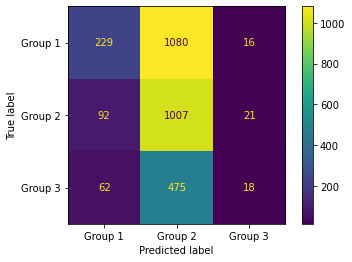

In [85]:
#plotting Confussion Matrix
#fig, axs = plt.subplots(ncols=3, figsize=(12,5))
cm_display1 = ConfusionMatrixDisplay(confusion_matrix = cm_cart, display_labels = class_names)


cm_display1.plot()

plt.show()

## 2.4 Random Forest Classification Model

In [86]:
from sklearn.ensemble import RandomForestClassifier
import time

grid_values = {'max_features': np.linspace(1,100,100, dtype='int32'),
              'min_samples_leaf': [5],
              'n_estimators': [100],
              'random_state': [88]} 

tic = time.time()

rf = RandomForestClassifier(class_weight = 'balanced') 
rf_cv = GridSearchCV(rf, param_grid=grid_values, scoring='accuracy', cv=10)
rf_cv.fit(train_x, train_y)

toc = time.time()
print('time:', round(toc-tic, 2),'s')

time: 5948.82 s


(0.3, 0.6)

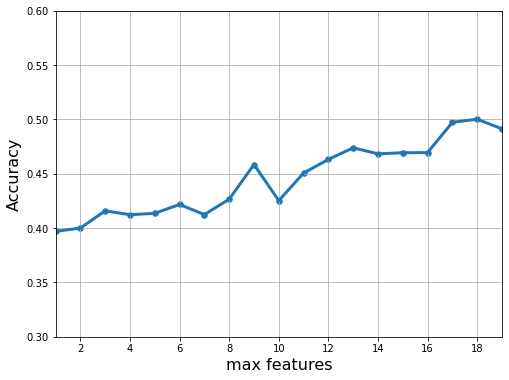

In [87]:
max_features = rf_cv.cv_results_['param_max_features'].data
R2_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([1, 19])
plt.ylim([0.3, 0.6])

In [88]:
print(rf_cv.best_params_)

{'max_features': 98, 'min_samples_leaf': 5, 'n_estimators': 100, 'random_state': 88}


In [89]:
y_pred = rf_cv.predict(test_x)

cm_rf = confusion_matrix(test_y, y_pred)

print('Model Precision (R2):', round(rf_cv.best_score_, 5))
RF_OSR2 = precision_score(test_y, y_pred, average='micro')
print('Model Precision (OSR2):', round(RF_OSR2, 5))

Model Precision (R2): 0.58671
Model Precision (OSR2): 0.56733


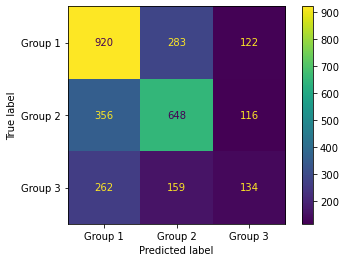

In [90]:
#plotting Confussion Matrix

cm_display2 = ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels = class_names)


cm_display2.plot()

plt.show()

## 2.5  Bootstrap Validation with Confidence Interval Plot 

**Since our best model is Random Forest model with OSR2 of 0.56733, we will like to know with certainty how it will perform on future data**

In [91]:
# manual implementation of bootstrap for model valiation.
def bootstrap_validation2(test_data, test_label, train_label, model, metrics_list, sample=500, random_state=66):
    n_sample = sample
    n_metrics = len(metrics_list)
    output_array=np.zeros([n_sample, n_metrics])
    output_array[:]=np.nan
    print(output_array.shape)
    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        for metrics_iter in range(n_metrics):
            metrics = metrics_list[metrics_iter]
            output_array[bs_iter, metrics_iter]=metrics(bs_label, bs_predicted, average='micro')                                                                                                                                                                                                                                                                                                         
    output_df = pd.DataFrame(output_array)
    return output_df

In [97]:
#Carrying out Bootstrap for CART Model
bs_output_rf = bootstrap_validation2(test_x,test_y,train_y,rf_cv,
                                 metrics_list=[precision_score],
                                 sample = 5000)

(5000, 1)


(array([  1.,   4.,  14.,  24.,  67., 138., 245., 388., 557., 785., 756.,
        665., 537., 389., 214., 128.,  59.,  15.,   9.,   5.]),
 array([-0.03566667, -0.03223333, -0.0288    , -0.02536667, -0.02193333,
        -0.0185    , -0.01506667, -0.01163333, -0.0082    , -0.00476667,
        -0.00133333,  0.0021    ,  0.00553333,  0.00896667,  0.0124    ,
         0.01583333,  0.01926667,  0.0227    ,  0.02613333,  0.02956667,
         0.033     ]),
 <BarContainer object of 20 artists>)

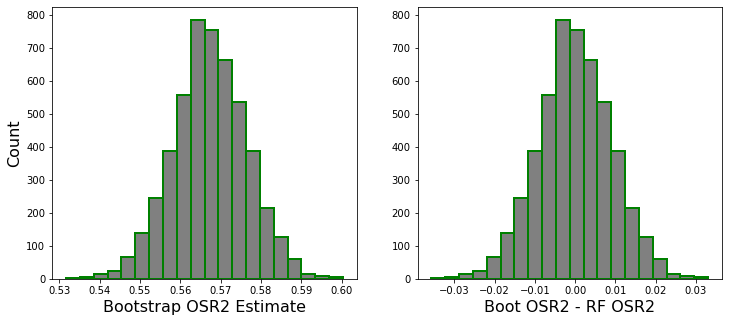

In [98]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Bootstrap OSR2 Estimate', fontsize=16)
axs[1].set_xlabel('Boot OSR2 - RF OSR2', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bs_output_rf.iloc[:,0], bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[1].hist(bs_output_rf.iloc[:,0]-RF_OSR2, bins=20,edgecolor='green', linewidth=2,color = "grey")

In [99]:
# The 95% confidence interval
CI_RF = np.quantile(bs_output_rf.iloc[:,0]-RF_OSR2,np.array([0.025,0.975]))
print("The 95-percent confidence interval of OSR2 is %s" % CI_RF)

The 95-percent confidence interval of OSR2 is [-0.018       0.01766667]


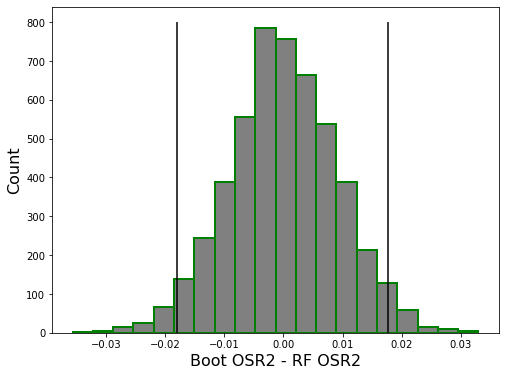

In [101]:
fig, axs = plt.subplots(ncols=1, figsize=(8,6))
axs.set_xlabel('Boot OSR2 - RF OSR2', fontsize=16)
axs.set_ylabel('Count', fontsize=16)
axs.hist(bs_output_rf.iloc[:,0]-RF_OSR2, bins=20,edgecolor='green', linewidth=2,color = "grey")
axs.vlines(x=CI_RF[0], ymin = 0, ymax =800, color = "black")
axs.vlines(x=CI_RF[1], ymin = 0, ymax =800, color = "black")

**In conclusion, since our confident interval contains Zero, we can say with 95% cofidence that our model will
generate very similar result on future datasets**